## Titanic: Machine Learning from Disaster 

The legendary kaggle challenge with more than 20,000 competing teams!

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

The data: 
    gender_submission.csv
    test.csv
    train.csv

The gender_submission.csv only serves as an example of how the final submission has to be output. It has no statistical meaning for the predictions.

The test.csv is the test set from which we will output our final results for submission. This set does not contain the ground truth for the survival, it is our job to predict it.

The train.csv is our training set, this is the set we are going to use the most and from which we will build our classfier (prediction model). It contains the ground truth (actual outcome) for each passenger in the set.

### Workflow

1. Data preprocessing

   1.1 Importing the libraries and data
   
   1.2 Exploratory Data Analysis
   
   1.3 Feature engineering
   
   1.4 Taking care of missing values
   
    
2. Modelling 

   2.1 Data modelling (dummy variables, feature scaling, splitting test set and training set)
   
   2.2 Fitting data to classifiers
   
   2.3 Evalutating the models.

#### Part 1: Data preprocessing

1.1 Importing libraries and dataset

In [1]:
# Importing the libraries

# libraries for data manipulation
import pandas as pd
import numpy as np

# libraries for plotting and visualisation
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # setting seaborn default for plots

from collections import Counter

# libraries for classifiers and ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
import xgboost as xgb

#for label encoding
from sklearn.preprocessing import LabelEncoder

# libraries for tuning hyperparameters and score evaluation
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, learning_curve

In [2]:
# Importing the dataset
trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')
# Union of datasets for feature engineering 
dataset = pd.concat([trainset, testset]).reset_index(drop=True)

1.2 Exploratory data analysis

In [3]:
#sample first rows of data
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#general info of data
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


We have 12 columns. 7 are numerical values and 5 are python objects, in this case strings.

PassengerId, Survived, Pclass, Age, SibSp, Parch and Fare have numerical values.

This allows us to check the correlation between these values in a heat map (exclude PassengerId).

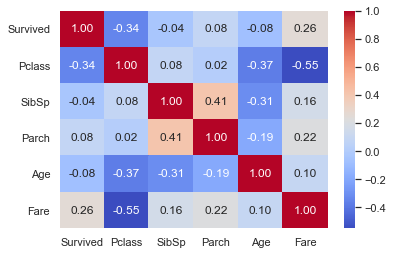

In [5]:
g = sns.heatmap(trainset[
    ["Survived","Pclass", "SibSp","Parch","Age","Fare"]].corr(),
                annot=True, fmt = ".2f", cmap = "coolwarm")


Pclass and Fare have a higher correlation to the survived column than the rest of the categories.

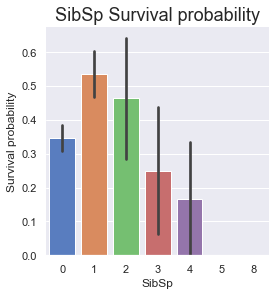

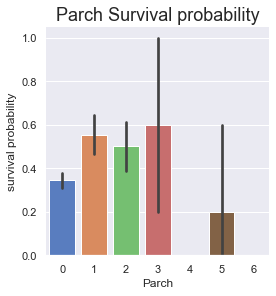

In [6]:
# Explore SibSp feature vs Survived
f = sns.catplot(x="SibSp",y="Survived",data=trainset,kind="bar", height= 4,
palette = "muted")
plt.title("SibSp Survival probability",fontsize=18)
f.despine(left=True)
f = f.set_ylabels("Survival probability")

# Explore Parch feature vs Survived
g  = sns.catplot(x="Parch",y="Survived",data=trainset,kind="bar",height = 4 , 
palette = "muted")
plt.title("Parch Survival probability",fontsize=18)
g.despine(left=True)
g = g.set_ylabels("survival probability")


The survival probability for SibSp seems to have groups of different probabilities.
alone(0): medium 
small family(1-2): high 
medium family(3-4): low 
big family(5+): very low

If group the values there might be a higher correlation to survival.

Results for Parch seem similar with a higher uncertainty rate.

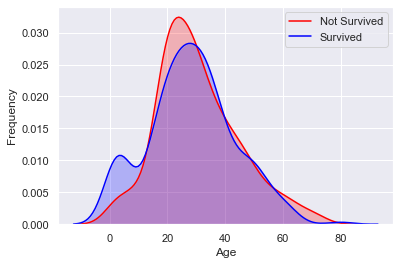

In [7]:
# Explore Age distibution 
g = sns.kdeplot(trainset["Age"][(trainset["Survived"] == 0) & (trainset["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(trainset["Age"][(trainset["Survived"] == 1) & (trainset["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

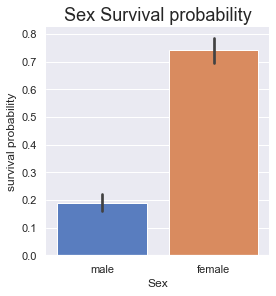

In [8]:
# Explore Parch feature vs Survived
g  = sns.catplot(x="Sex",y="Survived",data=trainset,kind="bar",height = 4 , 
palette = "muted")
plt.title("Sex Survival probability",fontsize=18)
g.despine(left=True)
g = g.set_ylabels("survival probability")

Values for age seem similar for the survival rate exept between 0 and 10, where the survival rate is much higher. This indicates that younger children have higher chances of survival.

The results are clear for the sex chart, women have a much higher chance of surviving.

"WOMEN AND CHILDREN FIRST"-An actor in the movie

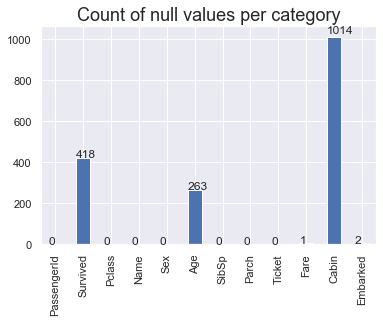

In [9]:
#Count of null values per category
ax = dataset.isnull().sum().plot(kind='bar')
ax.set_title("Count of null values per category", fontsize=18)
#ax.set_ylabel("# null values", fontsize=10);
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1.015))

Survived: 418 missing values, they are the values we have to predict so no processing here.
Age: 263 missing values, we will have to fill the values in the best way possible.
Fare: 1 missing value, we can simply put the median of prices for the other passengers.
Embarked: 2 missing values, we will do the same as for Fare, but with the most frequent category.
Cabin: Lots of missing values, is it worth it to process them ? 


n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64


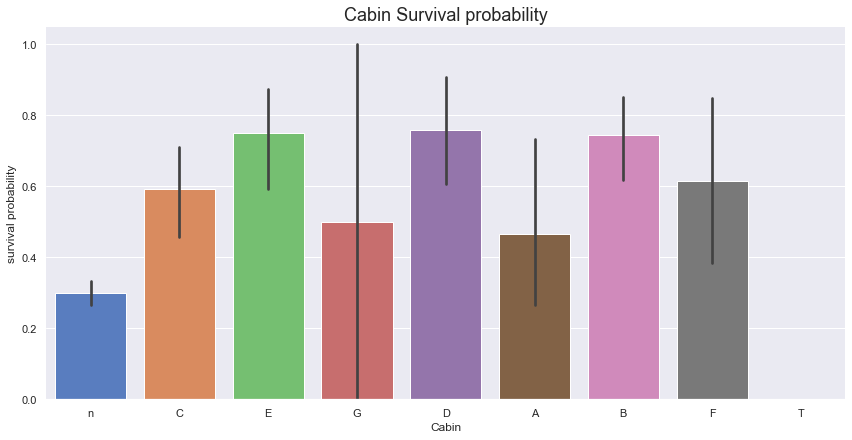

In [31]:
trainset["Cabin"]=trainset["Cabin"].astype(str).str[0]
print(trainset['Cabin'].value_counts())
# Explore Cabin-NoCabin vs Survived
g  = sns.catplot(x="Cabin" ,y="Survived",data=trainset,kind="bar",height = 6 , aspect= 2, 
palette = "muted")
plt.title("Cabin Survival probability",fontsize=18)
g.despine(left=True)
g = g.set_ylabels("survival probability")

People in cabins have a higher survival rate than people with no cabins. Except for t, where the survival rate for the 1 person is 0.

In [ ]:
1.3 Feature engineering

Since the Passengerid column is a unique numerical value for each passenger, it gives no indication as to if the passenger will survive. We already have the Row_id's which act as identifiers for the passengers making this feature redundant. Dropping this column seems obvious but we have to keep it for our submission form (see gender_submission.csv)

Now that we have a clearer view of the features, let's use some feature extracting on the Name column to create a title column.

Since the Mr and Mrs titles are usually used for adults and the Miss and Master titles for youth, this is going to help us fill the missing values of the Age column with more precise values by grouping per title for the medians.

In [25]:
#Split title from name
dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
# a litle info
print(dataset['Title'].value_counts())

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Major             2
Mlle              2
Jonkheer          1
the Countess      1
Capt              1
Sir               1
Dona              1
Don               1
Lady              1
Mme               1
Name: Title, dtype: int64


In [26]:
dataset.groupby('Title')['Survived'].value_counts() / dataset.groupby('Title')['Survived'].count()

Title         Survived
Capt          0.0         1.000000
Col           0.0         0.500000
              1.0         0.500000
Don           0.0         1.000000
Dr            0.0         0.571429
              1.0         0.428571
Jonkheer      0.0         1.000000
Lady          1.0         1.000000
Major         0.0         0.500000
              1.0         0.500000
Master        1.0         0.575000
              0.0         0.425000
Miss          1.0         0.697802
              0.0         0.302198
Mlle          1.0         1.000000
Mme           1.0         1.000000
Mr            0.0         0.843327
              1.0         0.156673
Mrs           1.0         0.792000
              0.0         0.208000
Ms            1.0         1.000000
Rev           0.0         1.000000
Sir           1.0         1.000000
the Countess  1.0         1.000000
Name: Survived, dtype: float64

In [27]:


##Thank you 
##https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
## for this next part

#replacing all titles with mr, mrs, miss, master with the exception of rev, because they have a high chance of dying.

def replace_titles(x):
    title=x['Title']
    if title in ['Sir', 'Don', 'Major', 'Capt', 'Jonkheer', 'Col']:
        return 'Mr'
    elif title in ['Lady', 'Dona',  'the Countess', 'Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
dataset['Title']=dataset.apply(replace_titles, axis=1)
print(dataset['Title'].value_counts())


Mr        767
Miss      264
Mrs       209
Master     61
Rev         8
Name: Title, dtype: int64


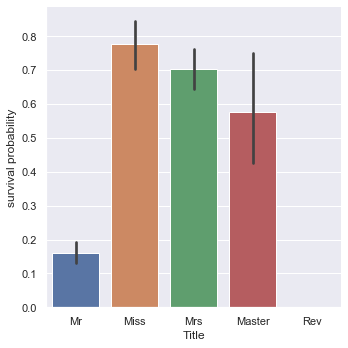

In [28]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Mr", "Miss", "Mrs", "Master", "Rev"])
g = g.set_ylabels("survival probability")

In [29]:
# Index of Nan age rows
idNan = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in idNan:
    age_med = dataset["Age"][(dataset['Title'] == dataset.iloc[i]["Title"])].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        ## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
        dataset['Age'].iloc[i] = age_pred
    else :
        ## complete missing age with median by title group
        dataset['Age'].iloc[i] = age_med
        
#Nan cleaning verification
print('Train columns with null values:\n', dataset.isnull().sum())
print("-"*10)

C:\Users\nikma\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Train columns with null values:
 PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Title             0
dtype: int64
----------


We still have some missing values on the embarked column.
For this column we can use the highest frequency value to complete our data.

In [33]:
#complete embarked with mode(highest frequency value)
dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
dataset['Cabin'].fillna("n", inplace = True)
dataset["Cabin"]=dataset["Cabin"].astype(str).str[0]
#Nan cleaning verification
print('columns with null values:\n', dataset.isnull().sum())
print("-"*10)

dataset.head()


columns with null values:
 PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
Title            0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,n,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,n,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,n,S,Mr


In [34]:
##Next in list is the ticket feature. 
print(dataset['Ticket'].value_counts())
## 681 ditinct values seems like a lot
dataset.loc[dataset['Ticket']=="CA. 2343"]
## but the data for each groups of tickets seems pretty correlated to 
## the survival outcome.

##Let's explore this feature further

CA. 2343        11
CA 2144          8
1601             8
3101295          7
S.O.C. 14879     7
                ..
345501           1
113794           1
A./5. 2152       1
113514           1
315093           1
Name: Ticket, Length: 929, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
159,160,0.0,3,"Sage, Master. Thomas Henry",male,14.5,8,2,CA. 2343,69.55,n,S,Master
180,181,0.0,3,"Sage, Miss. Constance Gladys",female,14.5,8,2,CA. 2343,69.55,n,S,Miss
201,202,0.0,3,"Sage, Mr. Frederick",male,14.5,8,2,CA. 2343,69.55,n,S,Mr
324,325,0.0,3,"Sage, Mr. George John Jr",male,14.5,8,2,CA. 2343,69.55,n,S,Mr
792,793,0.0,3,"Sage, Miss. Stella Anna",female,14.5,8,2,CA. 2343,69.55,n,S,Miss
846,847,0.0,3,"Sage, Mr. Douglas Bullen",male,14.5,8,2,CA. 2343,69.55,n,S,Mr
863,864,0.0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,14.5,8,2,CA. 2343,69.55,n,S,Miss
1079,1080,NaN,3,"Sage, Miss. Ada",female,14.5,8,2,CA. 2343,69.55,n,S,Miss
1233,1234,NaN,3,"Sage, Mr. John George",male,27.0,1,9,CA. 2343,69.55,n,S,Mr
1251,1252,NaN,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,n,S,Master


In [35]:
trainset['Ticket'].isin(testset['Ticket']).value_counts()
## we have 207 matching ticket values in the test and training set, this might help us in the accuracy of our results.

False    684
True     207
Name: Ticket, dtype: int64

In [36]:
label = LabelEncoder()
dataset['Ticket'] = label.fit_transform(dataset['Ticket'])


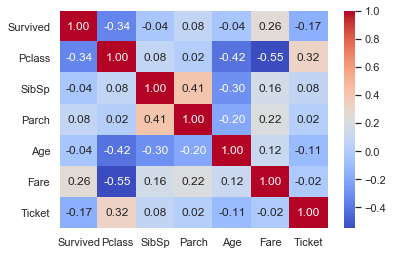

In [37]:
## lets see if all this trouble might be useful
g = sns.heatmap(dataset.iloc[0:891,:][
    ["Survived","Pclass", "SibSp","Parch","Age","Fare", "Ticket"]].corr(),
                annot=True, fmt = ".2f", cmap = "coolwarm")
##we have a correlation of 0.16 which is not as close to the 0.2 limit we would usually use but 
## we can keep it for now to see if it might change later.

As you can see, we only get results for numerical values and some values that we would consider important have very little correlation because of the number of values to consider. If we take the age value for an example, we have 88 different values to consider.

For that reason, grouping numerical values that have a big range of values is important in correlating the results. 

Converting categorical values into numerical bins.

Feature Engineering from family size to IsAlone and from ParCh to ParentChildren.
The chances of survival could vary depending on these factors: 
Alone or not and the size of your family present on board.

In [38]:
#Count the family size with siblings, s.o., parent or child.(+1 to include passenger himself)
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
#convert to boolean if the passenger is alone or not.
# Create new feature of family size
dataset['Single'] = dataset['FamilySize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['FamilySize'].map(lambda s: 1 if s >= 5 else 0)


In [40]:
dataset.drop(['Name', 'FamilySize'], axis = 1, inplace = True)

In [41]:
label = LabelEncoder()
dataset['Sex'] = label.fit_transform(dataset['Sex'])
dataset['Embarked'] = label.fit_transform(dataset['Embarked'])
dataset['Title'] = label.fit_transform(dataset['Title'])
dataset['Cabin'] = label.fit_transform(dataset['Cabin'])

In [42]:
dataset.iloc[0:891,:].corr(method='spearman')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Single,SmallF,MedF,LargeF
PassengerId,1.000000,-0.005007,-0.034091,0.042939,0.040420,-0.061161,0.001235,-0.055764,-0.013975,-0.024910,0.018105,0.068098,0.057462,-0.060548,0.027379,-0.057055
Survived,-0.005007,1.000000,-0.339668,-0.543351,-0.014309,0.088879,0.138266,-0.163354,0.323736,-0.311220,-0.160196,-0.079993,-0.203367,0.163157,0.193662,-0.125147
Pclass,-0.034091,-0.339668,1.000000,0.135775,-0.413294,-0.043019,-0.022801,0.323187,-0.688032,0.696350,0.091977,-0.136951,0.135896,-0.213005,-0.072750,0.162003
Sex,0.042939,-0.543351,0.135775,1.000000,0.078946,-0.195204,-0.254512,0.058398,-0.259593,0.133743,0.115412,0.102373,0.303646,-0.184774,-0.144848,-0.102954
Age,0.040420,-0.014309,-0.413294,0.078946,1.000000,-0.195495,-0.263971,-0.126441,0.151629,-0.273788,0.003831,0.456062,0.166884,0.078507,-0.134389,-0.252622
SibSp,-0.061161,0.088879,-0.043019,-0.195204,-0.195495,1.000000,0.450014,0.010680,0.447113,-0.047605,0.011157,-0.021982,-0.828215,0.380707,0.387501,0.477782
Parch,0.001235,0.138266,-0.022801,-0.254512,-0.263971,0.450014,1.000000,0.001060,0.410074,-0.076168,0.028365,-0.150319,-0.683719,-0.030751,0.593318,0.535635
Ticket,-0.055764,-0.163354,0.323187,0.058398,-0.126441,0.010680,0.001060,1.000000,-0.171300,0.259414,-0.016769,-0.068419,0.028174,-0.050580,-0.054283,0.097853
Fare,-0.013975,0.323736,-0.688032,-0.259593,0.151629,0.447113,0.410074,-0.171300,1.000000,-0.550283,-0.074873,0.030974,-0.531472,0.283435,0.246054,0.251052
Cabin,-0.024910,-0.311220,0.696350,0.133743,-0.273788,-0.047605,-0.076168,0.259414,-0.550283,1.000000,0.147778,-0.053973,0.151382,-0.199710,-0.050522,0.081179


Convert categorical features to dummy variables

In [43]:
todummy = ['Pclass', 'Sex', 'Embarked', 'Title', "Cabin"]
for feature in todummy:  
    dummies = pd.get_dummies(dataset[feature], prefix = feature, drop_first= True)
    dataset = pd.concat([dataset, dummies], axis = 1)
    dataset.drop([feature], axis=1, inplace = True)
dataset.head()

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Single,SmallF,MedF,...,Title_3,Title_4,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Cabin_7,Cabin_8
0,1,0.0,22.0,1,0,720,7.2500,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1.0,38.0,1,0,816,71.2833,0,1,0,...,1,0,0,1,0,0,0,0,0,0
2,3,1.0,26.0,0,0,914,7.9250,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1.0,35.0,1,0,65,53.1000,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,35.0,0,0,649,8.0500,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Splitting the dataset into dependent and independent variables.
Splitting datasets into test set and training set for model validation.

In [44]:
dataset.iloc[890:893,:]

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Single,SmallF,MedF,...,Title_3,Title_4,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Cabin_7,Cabin_8
890,891,0.0,32.0,0,0,642,7.7500,1,0,0,...,0,0,0,0,0,0,0,0,0,1
891,892,NaN,34.5,0,0,376,7.8292,1,0,0,...,0,0,0,0,0,0,0,0,0,1
892,893,NaN,47.0,1,0,582,7.0000,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [45]:
X = dataset.iloc[0:891, 2: ].values
y = dataset.iloc[0:891, 1].values
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [46]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [47]:
kfold = StratifiedKFold(n_splits=10)
random_state = 0
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(SVC(kernel='linear'))
classifiers.append(GaussianNB())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(xgb.XGBClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(
        classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))


cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({
    "CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":[
    "SVC","Linear SVM","Naive Baye's","DecisionTree","AdaBoost",
    "RandomForest","ExtraTrees","GradientBoosting",
    "MultipleLayerPerceptron","KNeighboors","LogisticRegression",
    "LinearDiscriminantAnalysis","XGB"]})


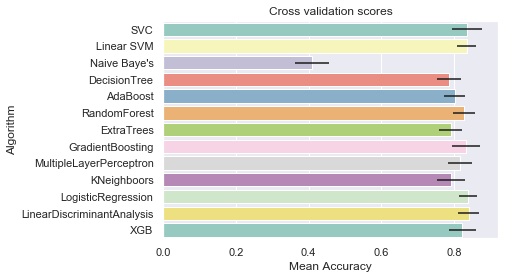

In [48]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

For ensemble modeling
SVC
RandomForest
GradientBoosting
MultipleLayerPerceptron
LinearDiscriminantAnalysis
XGB

In [51]:
##Metamodeling

In [52]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, refit = True, verbose = 1)
gsSVMC.fit(X_train,y_train)
SVMC_best = gsSVMC.best_estimator_
# Best score
print(gsSVMC.best_score_)
print(gsSVMC.best_params_)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 236 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   41.9s finished


0.8428012519561815
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [53]:
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, refit = True, verbose = 1)
gsRFC.fit(X_train,y_train)
RFC_best = gsRFC.best_estimator_
# Best score
print(gsRFC.best_score_)
print(gsRFC.best_params_)


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.8min finished


0.8357785602503913
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 3, 'n_estimators': 300}


In [54]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, refit = True, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
print(gsGBC.best_score_)
print(gsGBC.best_params_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   26.4s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   48.7s finished


0.832942097026604
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.3, 'min_samples_leaf': 150, 'n_estimators': 300}


In [55]:
#XGB

XGB = xgb.XGBClassifier()
gb_param_grid =     {"n_estimators": [125, 150],
     "max_depth": [6, 8, 10],
     "learning_rate": [0.01, 0.1, 0.001]}

gsXGB= GridSearchCV(XGB,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, refit = True, verbose = 1)

gsXGB.fit(X_train,y_train)

XGB_best = gsXGB.best_estimator_

# Best score
print(gsXGB.best_score_)
print(gsXGB.best_params_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   29.7s finished


0.8358763693270734
{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 150}


In [56]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, refit =True, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
print(gsExtC.best_score_)
print(gsExtC.best_params_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min


0.8371087636932707
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}


[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.5min finished


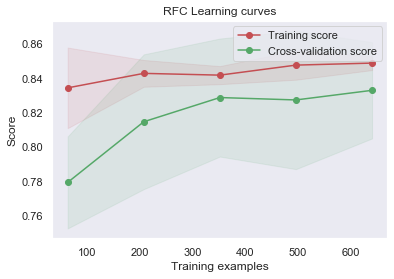

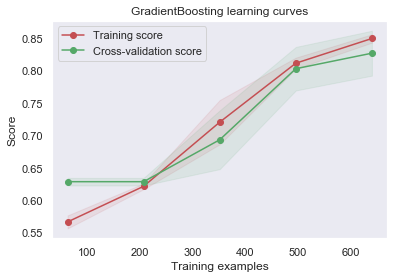

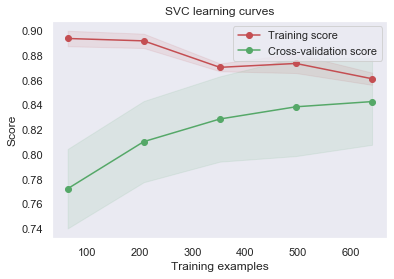

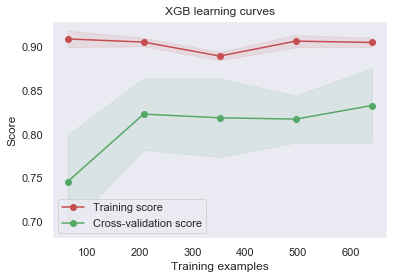

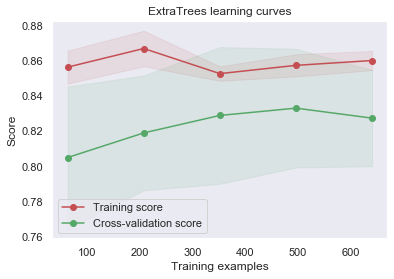

In [57]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RFC Learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsXGB.best_estimator_,"XGB learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)

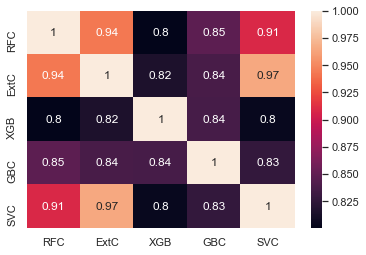

In [58]:
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X_test), name="SVC")
test_Survived_XGB = pd.Series(XGB_best.predict(X_test), name="XGB")
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_XGB,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [59]:
X_train = dataset.iloc[:891, 2: ].values
y_train = dataset.iloc[:891, 1].values
X_test = dataset.iloc[891:, 2: ].values
y_test = dataset.iloc[891:, 1].values


In [60]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('xgb',XGB_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [61]:
votingC.predict(X_test)

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [62]:

y_pred = votingC.predict(X_test).astype(int)
submission = pd.DataFrame({
        "PassengerId": dataset.iloc[891:, 0].values,
        "Survived": y_pred
    })

submission.to_csv("submission.csv",index=False)
